In [5]:
def createMatrices(file, word2Idx, pos_tags_dict, maxSentenceLen=100):
    """Creates matrices for the events and sentence for the given file"""
    labels = []
    positionMatrix1 = []
    positionMatrix2 = []
    e1Matrix = []
    e2Matrix = []
    tokenMatrix = []
    pos_tags_Matrix = []
    count = 0
    
    line_no = 0 
    for line in open(file):
        line_no += 1
        splits = line.strip().split('\t')
        
        label = splits[0]
        pos1 = splits[1]
        pos2 = splits[2]
        sentence = splits[3]
        tokens_postags = sentence.split(" ")
        
        tokens = []
        pos_tags = []
        
        for idx in range(len(tokens_postags)):
            if idx % 2 == 0:
                tokens.append(tokens_postags[idx])
            else:
                pos_tags.append(tokens_postags[idx])
                if tokens_postags[idx] not in pos_tags_dict:
                    pos_tags_dict[tokens_postags[idx]] = count
                    count += 1
        
        if len(tokens)!=len(pos_tags):
            print "false", line, line_no
        labelsDistribution[label] += 1
        
        tokenIds = np.zeros(maxSentenceLen)
        positionValues1 = np.zeros(maxSentenceLen)
        positionValues2 = np.zeros(maxSentenceLen)
        pos_tags_Ids = np.zeros(maxSentenceLen)
        e1 = 0
        e2 = 0
        
        for idx in xrange(0, min(maxSentenceLen, len(tokens))):
            tokenIds[idx] = getWordIdx(tokens[idx], word2Idx)
            pos_tags_Ids[idx] = pos_tags_dict[pos_tags[idx]]
            distance1 = idx - int(pos1)
            distance2 = idx - int(pos2)
            
            if distance1 == 0:
                e1 = tokenIds[idx]
            elif distance2 == 0:
                e2 = tokenIds[idx]
            
            if distance1 in distanceMapping:
                positionValues1[idx] = distanceMapping[distance1]
            elif distance1 <= minDistance:
                positionValues1[idx] = distanceMapping['LowerMin']
            else:
                positionValues1[idx] = distanceMapping['GreaterMax']
                
            if distance2 in distanceMapping:
                positionValues2[idx] = distanceMapping[distance2]
            elif distance2 <= minDistance:
                positionValues2[idx] = distanceMapping['LowerMin']
            else:
                positionValues2[idx] = distanceMapping['GreaterMax']
         
        pos_tags_Matrix.append(pos_tags_Ids)
        tokenMatrix.append(tokenIds)
        positionMatrix1.append(positionValues1)
        positionMatrix2.append(positionValues2)
        e1Matrix.append(e1)
        e2Matrix.append(e2)
        labels.append(labelsMapping[label])
        

    print pos_tags_dict
    return np.array(labels, dtype='int32'), np.array(tokenMatrix, dtype='int32'), np.array(pos_tags_Matrix, dtype='int32'), np.array(positionMatrix1, dtype='int32'), np.array(positionMatrix2, dtype='int32'), np.array(e1Matrix, dtype='int32'), np.array(e2Matrix, dtype='int32')

In [6]:
def getWordIdx(token, word2Idx): 
    """Returns from the word2Idex table the word index for a given token"""       
    if token in word2Idx:
        return word2Idx[token]
    elif token.lower() in word2Idx:
        return word2Idx[token.lower()]
    
    return word2Idx["UNKNOWN"]

In [7]:
# import cPickle as cpickle
# print("Loading W2V model")
# W2V_model = cpickle.load(open("Word2Vec_Model.p", "rb"))
# vocab = list(W2V_model.keys())
# print len(vocab)

In [8]:
import numpy as np
import cPickle as pkl
from nltk import FreqDist
import gzip

outputFilePath = 'pkl/sem-relations.pkl.gz'
embeddingsPklPath = 'pkl/embeddings.pkl.gz'

embeddingsPath = 'wiki.en.vec'

folder = 'files/'
files = [folder + 'train_ddi_new.txt', folder + 'test_ddi_new.txt']

#Mapping of the labels to integers
labelsMapping = {'false' : 0, 
                 'effect' : 1, 
                 'advise' : 2, 
                 'mechanism' : 3,
                 'int' : 4}

words = {}
pos_tags_dict = {}
maxSentenceLen = [0,0,0]
labelsDistribution = FreqDist()

distanceMapping = {'PADDING': 0, 'LowerMin': 1, 'GreaterMax': 2}
minDistance = -30
maxDistance = 30
for dis in xrange(minDistance,maxDistance+1):
    distanceMapping[dis] = len(distanceMapping)


for fileIdx in xrange(len(files)):
    file = files[fileIdx]
    print files[fileIdx]
    for line in open(file):
        splits = line.strip().split('\t')
        
        label = splits[0]
        
        
        sentence = splits[3]  
        tokens = sentence.split(" ")
        maxSentenceLen[fileIdx] = max(maxSentenceLen[fileIdx], len(tokens))
        for token in tokens:
            words[token.lower()] = True
    print len(words)

print "Max Sentence Lengths: ", maxSentenceLen, len(words)
        
# :: Read in word embeddings ::
word2Idx = {}
embeddings = []
count = 0
for line in open(embeddingsPath):
    split = line.strip().split(" ")
    word = split[0]
# for index, word in enumerate(vocab):
    if len(word2Idx) == 0: #Add padding+unknown
        word2Idx["PADDING"] = len(word2Idx)
        vector = np.zeros(300)
#         vector = np.zeros(50) #Zero vector vor 'PADDING' word
        embeddings.append(vector)
        
        word2Idx["UNKNOWN"] = len(word2Idx)
        vector = np.random.uniform(-0.25, 0.25, 300)
        embeddings.append(vector)

#     if word.lower() in words and word.lower() not in word2Idx:
#         vector = np.array(W2V_model[word])
    if split[0].lower() in words and split[0].lower() not in word2Idx:
        vector = np.array([float(num) for num in split[1:]])
        embeddings.append(vector)
        word2Idx[word.lower()] = len(word2Idx)
        count += 1
        
embeddings = np.array(embeddings)

print "Embeddings shape: ", embeddings.shape
print "Len words: ", len(words), count

f = gzip.open(embeddingsPklPath, 'wb')
pkl.dump(embeddings, f, -1)
f.close()

# :: Create token matrix ::
train_set = createMatrices(files[0], word2Idx, pos_tags_dict, max(maxSentenceLen))
print len(train_set)
test_set = createMatrices(files[1], word2Idx, pos_tags_dict, max(maxSentenceLen))
print len(test_set)

f = gzip.open(outputFilePath, 'wb')
pkl.dump(train_set, f, -1)
pkl.dump(test_set, f, -1)
f.close()

print "Data stored in pkl folder"

for label, freq in labelsDistribution.most_common(100):
    print "%s : %f%%" % (label, 100*freq / float(labelsDistribution.N()))

files/train_ddi_new.txt
5998
files/test_ddi_new.txt
6889
Max Sentence Lengths:  [146, 128, 0] 6889
Embeddings shape:  (1748, 300)
Len words:  6889 1746
{'vb': 10, 'cc': 7, 'topos': 9, 'jjs': 16, 'jjr': 18, 'cd': 15, 'prp': 20, 'nns': 8, 'nnp': 11, 'nnps': 29, 'wrb': 14, 'nn': 1, 'rb': 3, 'rbr': 27, 'fw': 23, 'pos': 28, 'jj': 6, 'wp': 26, 'rp': 24, 'dt': 0, 'md': 19, 'vbg': 4, 'vbd': 12, 'pdt': 30, 'rbs': 25, 'vbn': 13, 'inpos': 5, 'vbp': 2, 'wdt': 21, 'vbz': 17, 'ex': 22}
7
{'vb': 10, 'cc': 7, 'topos': 9, 'jjs': 16, 'jjr': 18, 'cd': 15, 'prp': 20, 'nns': 8, 'nnp': 11, 'nnps': 29, 'wrb': 14, 'nn': 1, 'rb': 3, 'rbr': 27, 'fw': 23, 'pos': 28, 'jj': 6, 'wp': 26, 'rp': 24, 'dt': 0, 'md': 19, 'vbg': 4, 'vbd': 12, 'pdt': 30, 'rbs': 25, 'vbn': 13, 'inpos': 5, 'vbp': 2, 'wdt': 21, 'vbz': 17, 'ex': 22}
7
Data stored in pkl folder
false : 69.650834%
effect : 12.261718%
mechanism : 9.820698%
advise : 6.505190%
int : 1.761560%


In [9]:
def getPrecision(pred_test, yTest, targetLabel):
    #Precision for non-vague
    targetLabelCount = 0
    correctTargetLabelCount = 0
    
    for idx in xrange(len(pred_test)):
        if pred_test[idx] == targetLabel:
            targetLabelCount += 1
            
            if pred_test[idx] == yTest[idx]:
                correctTargetLabelCount += 1
    
    if correctTargetLabelCount == 0:
        return 0
    
    return float(correctTargetLabelCount) / targetLabelCount

In [10]:
import numpy as np
np.random.seed(1337)  # for reproducibility

import cPickle as pkl
import gzip
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Merge, LSTM, Input
from keras.layers.embeddings import Embedding
from keras.layers import Convolution1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.wrappers import Bidirectional
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


batch_size = 64
nb_filter = 100
filter_length = 3
hidden_dims = 100
nb_epoch = 50
position_dims = 50

print "Load dataset"
f = gzip.open('pkl/sem-relations.pkl.gz', 'rb')
yTrain, sentenceTrain, pos_tags_train, positionTrain1, positionTrain2, e1Train, e2Train = pkl.load(f)
yTest, sentenceTest, pos_tags_test, positionTest1, positionTest2, e1Test, e2Test  = pkl.load(f)
f.close()

max_position = max(np.max(positionTrain1), np.max(positionTrain2))+1

n_out = max(yTrain)+1
train_y_cat = np_utils.to_categorical(yTrain, n_out)


print "sentenceTrain: ", sentenceTrain.shape
print "positionTrain1: ", positionTrain1.shape
print "e1Train: ", e1Train.shape
print "e2Train: ", e2Train.shape
print "yTrain: ", yTrain.shape

print "sentenceTest: ", sentenceTest.shape
print "positionTest1: ", positionTest1.shape
print "e1Test: ", e1Test.shape
print "e2Test: ", e2Test.shape
print "yTest: ", yTest.shape


f = gzip.open('pkl/embeddings.pkl.gz', 'rb')
embeddings = pkl.load(f)
f.close()

print "Embeddings: ",embeddings.shape

Using TensorFlow backend.


Load dataset
sentenceTrain:  (12840, 146)
positionTrain1:  (12840, 146)
e1Train:  (12840,)
e2Train:  (12840,)
yTrain:  (12840,)
sentenceTest:  (3055, 146)
positionTest1:  (3055, 146)
e1Test:  (3055,)
e2Test:  (3055,)
yTest:  (3055,)
Embeddings:  (1748, 300)


/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]
/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", padding="same", strides=1, filters=100, kernel_size=3)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 146, 400)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 100)          120100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 651,405
Trainable params: 127,005
Non-trainable params: 524,400
_________________________________________________________________


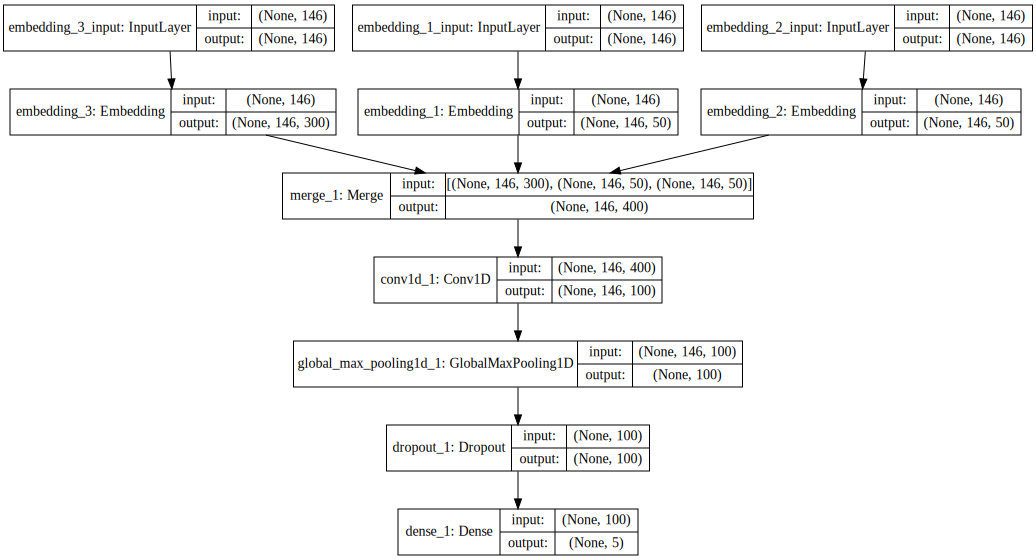

In [11]:
#without POS
distanceModel1 = Sequential()
distanceModel1.add(Embedding(max_position, position_dims, input_length=positionTrain1.shape[1]))

distanceModel2 = Sequential()
distanceModel2.add(Embedding(max_position, position_dims, input_length=positionTrain2.shape[1]))

wordModel = Sequential()
wordModel.add(Embedding(embeddings.shape[0], embeddings.shape[1], input_length=sentenceTrain.shape[1], weights=[embeddings], trainable=False))


model = Sequential()
model.add(Merge([wordModel, distanceModel1, distanceModel2], mode='concat'))


model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='same',
                        activation='tanh',
                        subsample_length=1))
# we use standard max over time pooling
model.add(GlobalMaxPooling1D())

model.add(Dropout(0.25))
model.add(Dense(n_out, activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
model.summary()
SVG(model_to_dot(model, show_shapes="True", show_layer_names="False").create(prog='dot', format='svg'))

In [12]:
print "Start training"
max_prec, max_rec, max_acc, max_f1 = 0,0,0,0
for epoch in xrange(nb_epoch):       
    model.fit([sentenceTrain, positionTrain1, positionTrain2], train_y_cat, batch_size=batch_size, verbose=True,nb_epoch=1)   
    pred_test = model.predict_classes([sentenceTest, positionTest1, positionTest2], verbose=False)
    
    dctLabels = np.sum(pred_test)
    totalDCTLabels = np.sum(yTest)
   
    acc =  np.sum(pred_test == yTest) / float(len(yTest))
    max_acc = max(max_acc, acc)
    print "Accuracy: %.4f (max: %.4f)" % (acc, max_acc)

    f1Sum = 0
    f1Count = 0
    for targetLabel in xrange(1, max(yTest)):        
        prec = getPrecision(pred_test, yTest, targetLabel)
        rec = getPrecision(yTest, pred_test, targetLabel)
        f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
        f1Sum += f1
        f1Count +=1    
        
        
    macroF1 = f1Sum / float(f1Count)    
    max_f1 = max(max_f1, macroF1)
    print "Non-other Macro-Averaged F1: %.4f (max: %.4f)\n" % (macroF1, max_f1)

Start training


/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
12840/12840 [==============================] - 4s - loss: 0.7973 - acc: 0.7139       

/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  app.launch_new_instance()
/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", padding="same", strides=1, filters=100, kernel_size=3)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_2 (Merge)              (None, 146, 450)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 146, 100)          135100    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 667,955
Trainable params: 143,555
Non-trainable params: 524,400
_________________________________________________________________


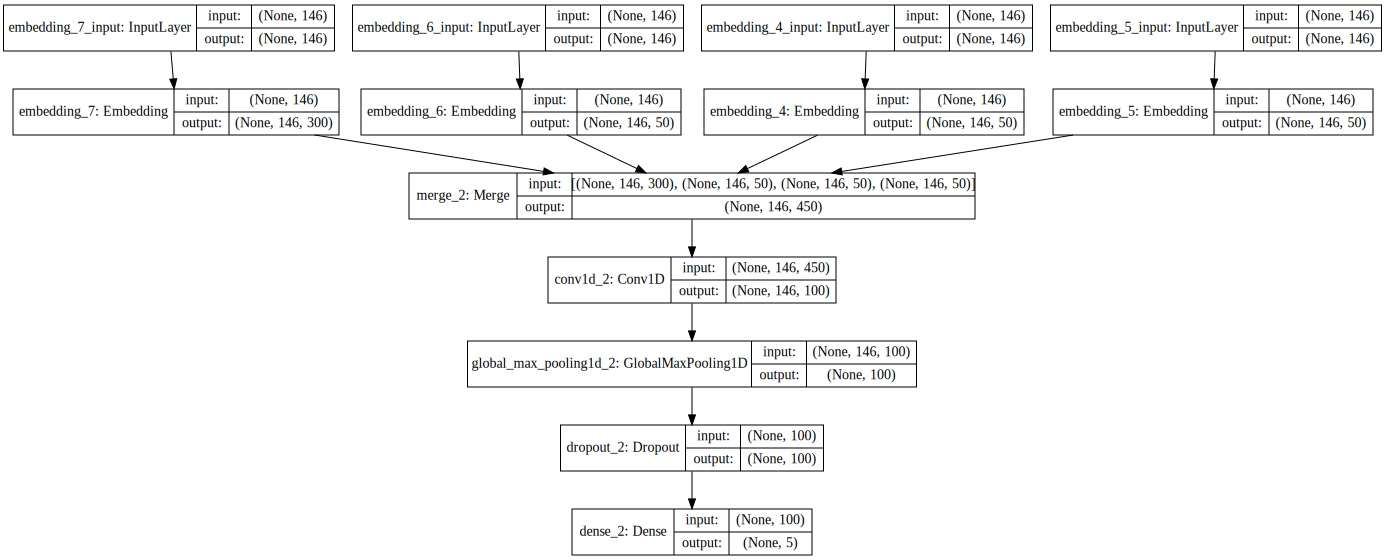

In [13]:
#with POS
distanceModel1 = Sequential()
distanceModel1.add(Embedding(max_position, position_dims, input_length=positionTrain1.shape[1]))

distanceModel2 = Sequential()
distanceModel2.add(Embedding(max_position, position_dims, input_length=positionTrain2.shape[1]))

POSModel2 = Sequential()
POSModel2.add(Embedding(len(pos_tags_dict), position_dims, input_length=pos_tags_train.shape[1]))

wordModel = Sequential()
wordModel.add(Embedding(embeddings.shape[0], embeddings.shape[1], input_length=sentenceTrain.shape[1], weights=[embeddings], trainable=False))


model = Sequential()
model.add(Merge([wordModel, POSModel2, distanceModel1, distanceModel2], mode='concat'))


model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='same',
                        activation='tanh',
                        subsample_length=1))
# we use standard max over time pooling
model.add(GlobalMaxPooling1D())

model.add(Dropout(0.25))
model.add(Dense(n_out, activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
model.summary()
SVG(model_to_dot(model, show_shapes="True", show_layer_names="False").create(prog='dot', format='svg'))

In [14]:
print "Start training"
max_prec, max_rec, max_acc, max_f1 = 0,0,0,0
for epoch in xrange(nb_epoch):       
    model.fit([sentenceTrain, pos_tags_train, positionTrain1, positionTrain2], train_y_cat, batch_size=batch_size, verbose=True,nb_epoch=1)   
    pred_test = model.predict_classes([sentenceTest, pos_tags_test, positionTest1, positionTest2], verbose=False)
    
    dctLabels = np.sum(pred_test)
    totalDCTLabels = np.sum(yTest)
   
    acc =  np.sum(pred_test == yTest) / float(len(yTest))
    max_acc = max(max_acc, acc)
    print "Accuracy: %.4f (max: %.4f)" % (acc, max_acc)

    f1Sum = 0
    f1Count = 0
    for targetLabel in xrange(1, max(yTest)):        
        prec = getPrecision(pred_test, yTest, targetLabel)
        rec = getPrecision(yTest, pred_test, targetLabel)
        f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
        f1Sum += f1
        f1Count +=1    
        
        
    macroF1 = f1Sum / float(f1Count)    
    max_f1 = max(max_f1, macroF1)
    print "Non-other Macro-Averaged F1: %.4f (max: %.4f)\n" % (macroF1, max_f1)

Start training
Epoch 1/1
12840/12840 [==============================] - 1s - loss: 0.7714 - acc: 0.7188      

In [15]:
from keras.layers import Dense, Dropout, Activation, Flatten, Merge, LSTM, Input, merge, Lambda, average, multiply, Dot, dot
from keras.models import Sequential, Model
import keras.backend.tensorflow_backend as K
from keras.regularizers import l2
from keras.callbacks import *
from keras.models import *
from keras.optimizers import *
from keras.layers.core import *
from keras.layers import Input, Embedding, LSTM, Dense, merge, TimeDistributed


In [16]:
def get_U_w(X):
    ans = X  # get last element from time dim
    return ans

def get_R(X):
    U_w, vecT = X[0], X[1]
    print U_w.shape, vecT.shape
    ans = K.batch_dot(U_w, vecT)
    return ans

def getTranspose(X):
    ans = K.permute_dimensions(X,(0,2,1))
    return ans

A1 (?, 146, 1)
A2 (?, 146, 1)
(?, 146, 300)


/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:49: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", padding="same", strides=1, filters=100, kernel_size=3)`


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 146)           0                                            
____________________________________________________________________________________________________
embedding_11 (Embedding)         (None, 146, 300)      524400      input_4[0][0]                    
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 146, 1)        0           embedding_11[0][0]               
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 146, 1)        0           embedding_11[0][0]               
___________________________________________________________________________________________

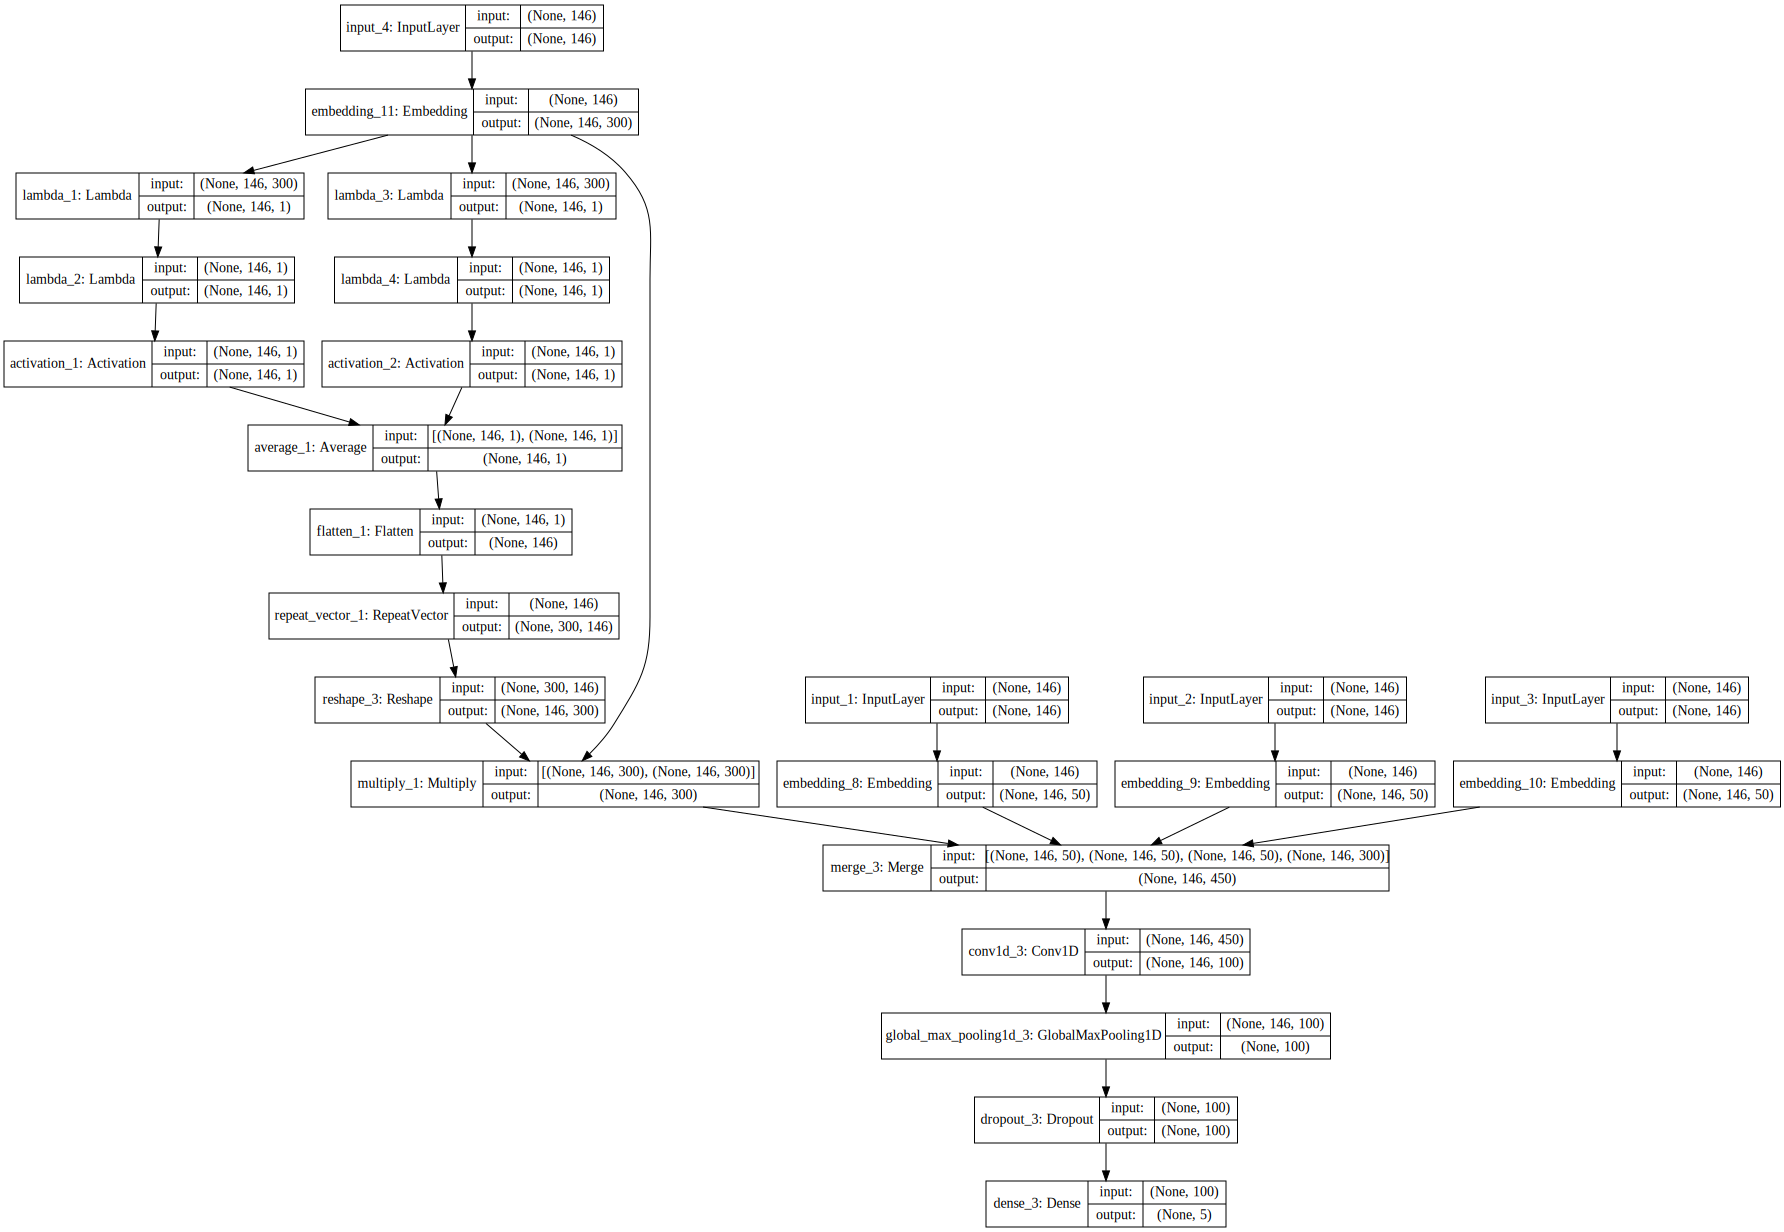

In [17]:
#with POS and non trainable attention
Input1 = Input(shape=(146,))
distanceModel1 = Embedding(max_position, position_dims, input_length=positionTrain1.shape[1])(Input1)

Input2 = Input(shape=(146,))
distanceModel2 = Embedding(max_position, position_dims, input_length=positionTrain2.shape[1])(Input2)

Input6 = Input(shape=(146,))
POSModel2 =Embedding(len(pos_tags_dict), position_dims, input_length=pos_tags_train.shape[1])(Input6)


Input3 = Input(shape=(146,))
Input4 = Input(shape=(1,))
Input5 = Input(shape=(1,))
wordModel = Input3
wordModel = Embedding(embeddings.shape[0], embeddings.shape[1], 
                      input_length=sentenceTrain.shape[1], weights=[embeddings], trainable=False)(wordModel)
e1Model = Input4
e1Model = Embedding(embeddings.shape[0], embeddings.shape[1], 
                      input_length=1, weights=[embeddings], trainable=False)(Input4)
e2Model = Input5
e2Model = Embedding(embeddings.shape[0], embeddings.shape[1], 
                      input_length=1, weights=[embeddings], trainable=False)(Input5)


x_embed = wordModel
e1_embed = e1Model
e1_embed =  Reshape([300,1])(e1_embed)
e2_embed = e2Model
e2_embed =  Reshape([300,1])(e2_embed)

A1 = Lambda(lambda x: K.batch_dot(x, e1_embed))(x_embed)
A1 = Lambda(lambda x: x / 300)(A1)
print "A1", A1.shape

A2 = Lambda(lambda x: K.batch_dot(x, e2_embed))(x_embed)
A2 = Lambda(lambda x: x / 300)(A2)
print "A2", A2.shape

alpha1 = Activation("softmax")(A1)
alpha2 = Activation("softmax")(A2)
alpha = average([alpha1, alpha2])
alpha = Flatten()(alpha)
alpha = RepeatVector(300)(alpha)
alpha = Reshape([146, 300])(alpha)
print alpha.shape
att_output = multiply([x_embed, alpha])

c_models = merge([distanceModel1, distanceModel2, POSModel2, att_output], mode='concat', concat_axis=-1)
#c_models = Bidirectional(LSTM(150))(c_models)
c_models = Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='same',
                        activation='tanh',
                        subsample_length=1)(c_models)

c_models = GlobalMaxPooling1D()(c_models)
c_models = Dropout(0.25)(c_models)
c_models = Dense(n_out, activation='softmax')(c_models)

main_model = Model(inputs=[Input1, Input2, Input6, Input3, Input4, Input5], outputs=c_models)
main_model.compile(loss='categorical_crossentropy',optimizer='rmsprop')
main_model.summary()
SVG(model_to_dot(main_model, show_shapes="True", show_layer_names="False").create(prog='dot', format='svg'))

In [18]:
print "Start training"
max_prec, max_rec, max_acc, max_f1 = 0,0,0,0
for epoch in xrange(50):
    print epoch
    main_model.fit([positionTrain1, positionTrain2, pos_tags_train, sentenceTrain, e1Train, e2Train], train_y_cat, batch_size=batch_size, verbose=True,nb_epoch=1)   
    pred_vals = main_model.predict([ positionTest1, positionTest2, pos_tags_test, sentenceTest, e1Test, e2Test], verbose=False)
    pred_test = []
    for idx in range(len(pred_vals)):
        pred_test.append(np.argmax(pred_vals[idx]))

    pred_test=np.array(pred_test)
    dctLabels = np.sum(pred_test)
    totalDCTLabels = np.sum(yTest)

    acc =  np.sum(pred_test == yTest) / float(len(yTest))
    max_acc = max(max_acc, acc)
    print "Accuracy: %.4f (max: %.4f)" % (acc, max_acc)

    f1Sum = 0
    f1Count = 0
    for targetLabel in xrange(0, max(yTest)+1):        
        prec = getPrecision(pred_test, yTest, targetLabel)
        rec = getPrecision(yTest, pred_test, targetLabel)
        f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
        #print f1
        f1Sum += f1
        f1Count +=1    


    macroF1 = f1Sum / float(f1Count)    
    max_f1 = max(max_f1, macroF1)
    print "Non-other Macro-Averaged F1: %.4f (max: %.4f)\n" % (macroF1, max_f1)

Start training
0


/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/1
12840/12840 [==============================] - 2s - loss: 0.7287      

In [19]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class MyLayer(Layer):

    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W_shape = (300,300)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.W_shape),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape)

(?, 146, 300)
(?, 146, 300)
(?, 146, 300) (?, 300, 1)
(?, 146, 1)
(?, 146, 300) (?, 300, 1)
(?, 146, 1)
(?, 146, 300)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 146)           0                                            
____________________________________________________________________________________________________
input_11 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
input_12 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_17 (Embedding)         (None, 146, 300)      524400      input_1

/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:49: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", padding="same", strides=1, filters=100, kernel_size=3)`


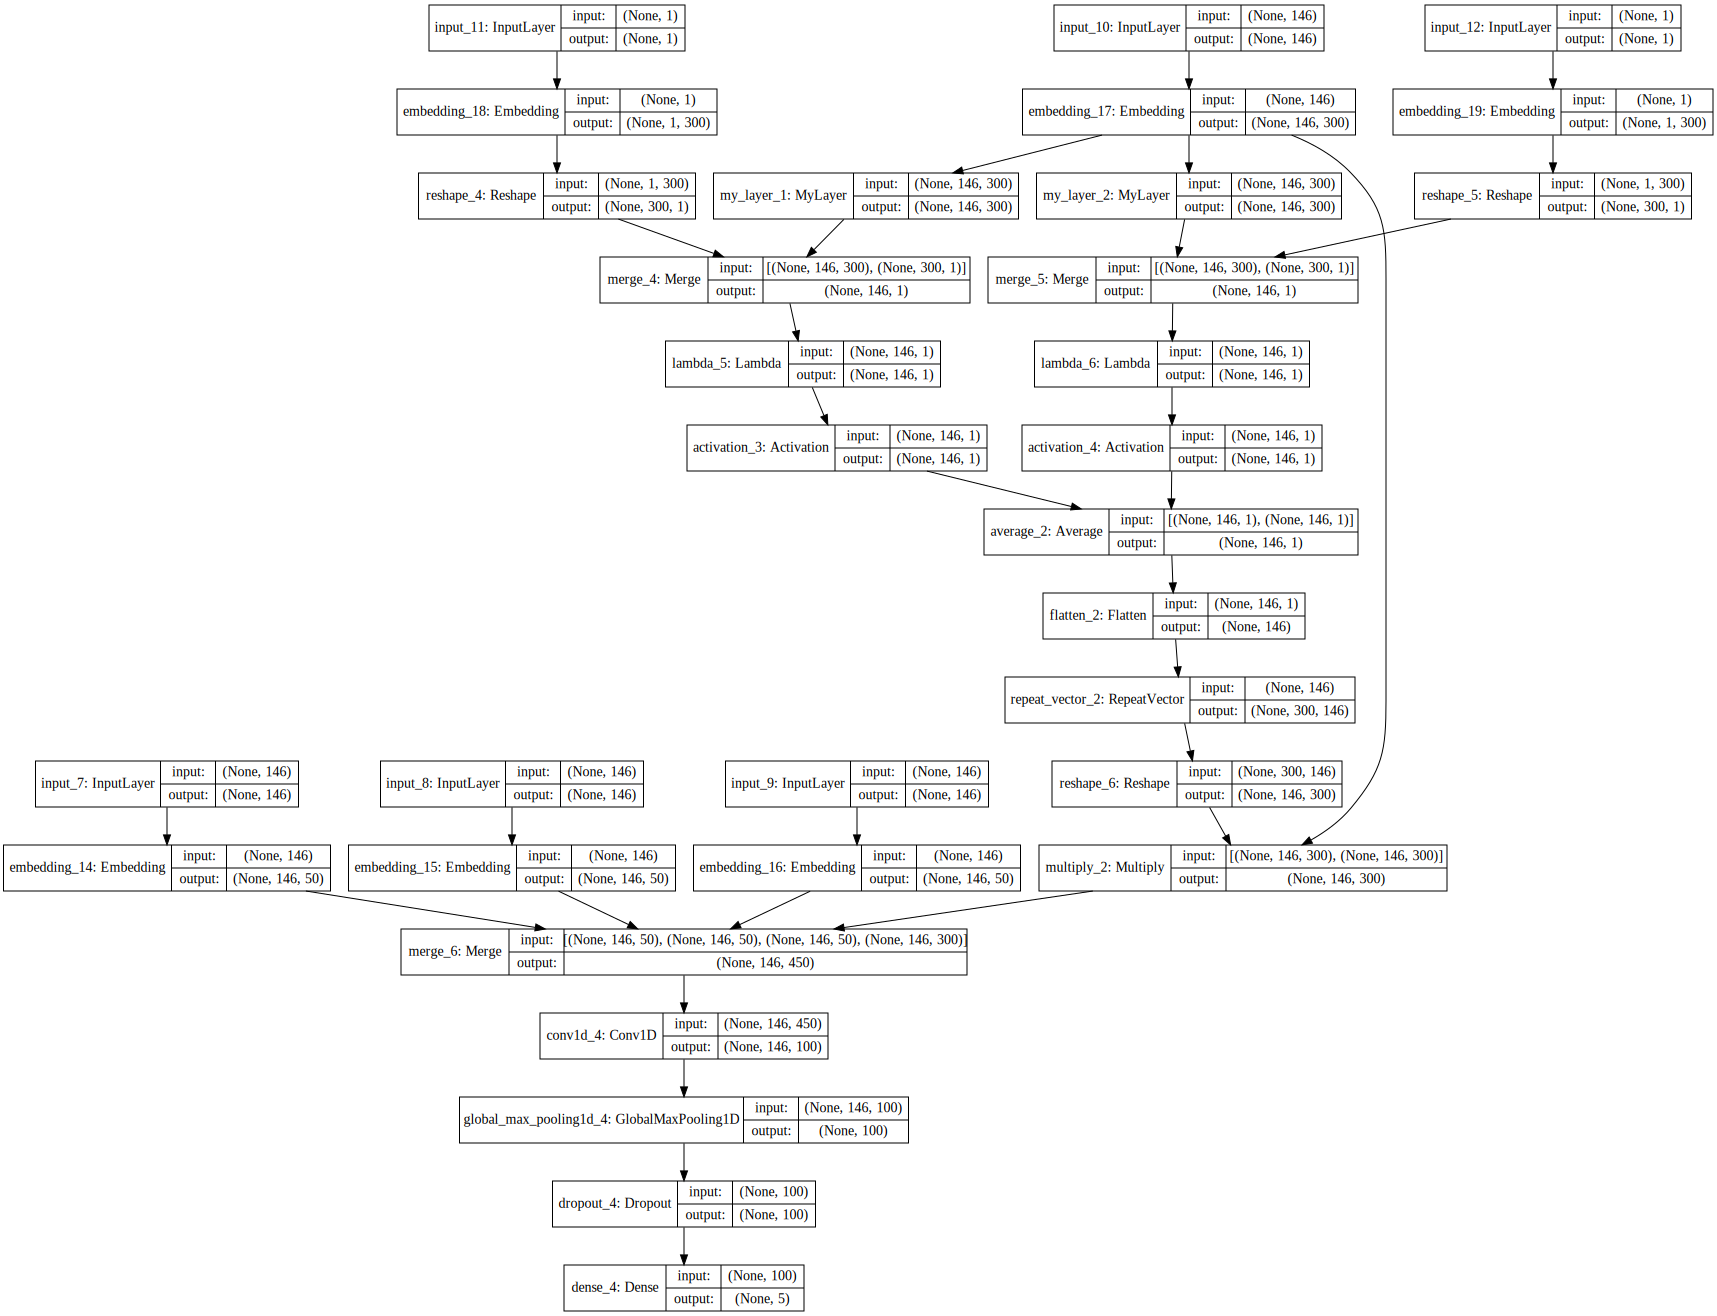

In [20]:
#with POS and trainable attention
Input1 = Input(shape=(146,))
distanceModel1 = Embedding(max_position, position_dims, input_length=positionTrain1.shape[1])(Input1)

Input2 = Input(shape=(146,))
distanceModel2 = Embedding(max_position, position_dims, input_length=positionTrain2.shape[1])(Input2)

Input6 = Input(shape=(146,))
POSModel2 =Embedding(len(pos_tags_dict), position_dims, input_length=pos_tags_train.shape[1])(Input6)

Input3 = Input(shape=(146,))
Input4 = Input(shape=(1,))
Input5 = Input(shape=(1,))
wordModel = Input3
wordModel = Embedding(embeddings.shape[0], embeddings.shape[1], 
                      input_length=sentenceTrain.shape[1], weights=[embeddings], trainable=False)(wordModel)
e1Model = Embedding(embeddings.shape[0], embeddings.shape[1], 
                      input_length=1, weights=[embeddings], trainable=False)(Input4)
e2Model = Embedding(embeddings.shape[0], embeddings.shape[1], 
                      input_length=1, weights=[embeddings], trainable=False)(Input5)


x_embed = wordModel
e1_embed = e1Model
e1_embed =  Reshape([300,1])(e1_embed)
e2_embed = e2Model
e2_embed =  Reshape([300,1])(e2_embed)

print x_embed.shape
W1x = MyLayer()(x_embed)
print W1x.shape
W2x = MyLayer()(x_embed)
A1 = merge([W1x, e1_embed], output_shape=(146, 1), mode=get_R)
A1 = Lambda(lambda x: x / 300)(A1)
print A1.shape
A2 = merge([W2x, e2_embed], output_shape=(146, 1), mode=get_R)
A2 = Lambda(lambda x: x / 300)(A2)
print A2.shape
alpha1 = Activation("softmax")(A1)
alpha2 = Activation("softmax")(A2)
alpha = average([alpha1, alpha2])
alpha = Flatten()(alpha)
alpha = RepeatVector(300)(alpha)
alpha = Reshape([146, 300])(alpha)
print alpha.shape
att_output = multiply([x_embed, alpha])


c_models = merge([distanceModel1, distanceModel2, POSModel2, att_output], mode='concat', concat_axis=-1)
#c_models = Bidirectional(LSTM(150))(c_models)
c_models = Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='same',
                        activation='tanh',
                        subsample_length=1)(c_models)

c_models = GlobalMaxPooling1D()(c_models)
c_models = Dropout(0.25)(c_models)
c_models = Dense(n_out, activation='softmax')(c_models)

main_model = Model(inputs=[Input1, Input2, Input6, Input3, Input4, Input5], outputs=c_models)
main_model.compile(loss='categorical_crossentropy',optimizer='rmsprop')
main_model.summary()
SVG(model_to_dot(main_model, show_shapes="True", show_layer_names="False").create(prog='dot', format='svg'))

In [21]:
print "Start training"
max_prec, max_rec, max_acc, max_f1 = 0,0,0,0
for epoch in xrange(50):
    print epoch
    main_model.fit([positionTrain1, positionTrain2, pos_tags_train, sentenceTrain, e1Train, e2Train], train_y_cat, batch_size=batch_size, verbose=True,nb_epoch=1)   
    pred_vals = main_model.predict([ positionTest1, positionTest2, pos_tags_test, sentenceTest, e1Test, e2Test], verbose=False)
    pred_test = []
    for idx in range(len(pred_vals)):
        pred_test.append(np.argmax(pred_vals[idx]))

    pred_test=np.array(pred_test)
    dctLabels = np.sum(pred_test)
    totalDCTLabels = np.sum(yTest)

    acc =  np.sum(pred_test == yTest) / float(len(yTest))
    max_acc = max(max_acc, acc)
    print "Accuracy: %.4f (max: %.4f)" % (acc, max_acc)

    f1Sum = 0
    f1Count = 0
    for targetLabel in xrange(0, max(yTest)+1):        
        prec = getPrecision(pred_test, yTest, targetLabel)
        rec = getPrecision(yTest, pred_test, targetLabel)
        f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
        #print f1
        f1Sum += f1
        f1Count +=1    


    macroF1 = f1Sum / float(f1Count)    
    max_f1 = max(max_f1, macroF1)
    print "Non-other Macro-Averaged F1: %.4f (max: %.4f)\n" % (macroF1, max_f1)

Start training
0


/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/1
12840/12840 [==============================] - 2s - loss: 0.7444      

(?, 146, 300)
(?, 146, 300)
(?, 146, 300) (?, 300, 1)
(?, 146, 1)
(?, 146, 300) (?, 300, 1)
(?, 146, 1)
(?, 146, 300)


/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:49: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", padding="same", strides=1, filters=100, kernel_size=3)`


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_16 (InputLayer)            (None, 146)           0                                            
____________________________________________________________________________________________________
input_17 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
input_18 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_23 (Embedding)         (None, 146, 300)      524400      input_16[0][0]                   
___________________________________________________________________________________________

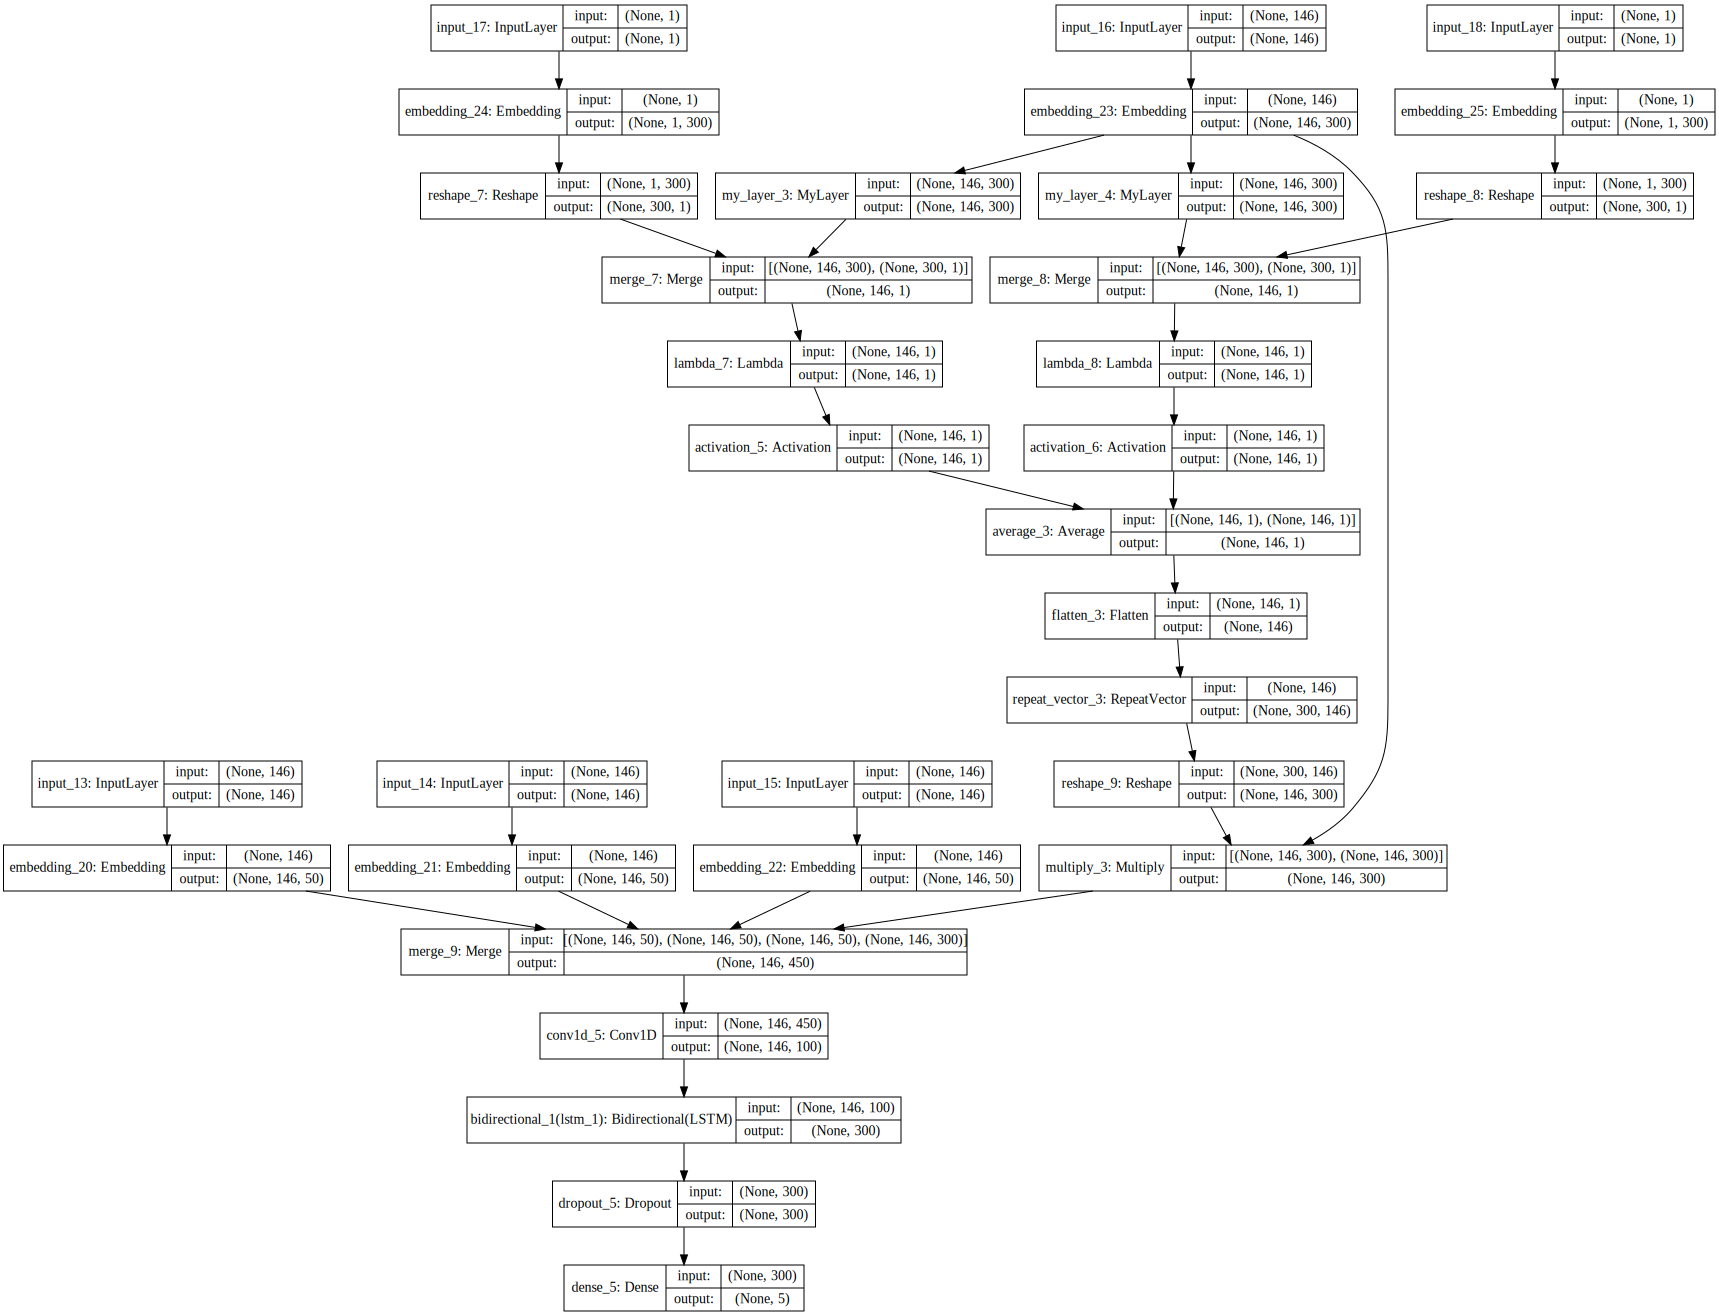

In [ ]:
#with POS and trainable attention and Bidirectional LSTM
Input1 = Input(shape=(146,))
distanceModel1 = Embedding(max_position, position_dims, input_length=positionTrain1.shape[1])(Input1)

Input2 = Input(shape=(146,))
distanceModel2 = Embedding(max_position, position_dims, input_length=positionTrain2.shape[1])(Input2)

Input6 = Input(shape=(146,))
POSModel2 =Embedding(len(pos_tags_dict), position_dims, input_length=pos_tags_train.shape[1])(Input6)

Input3 = Input(shape=(146,))
Input4 = Input(shape=(1,))
Input5 = Input(shape=(1,))
wordModel = Input3
wordModel = Embedding(embeddings.shape[0], embeddings.shape[1], 
                      input_length=sentenceTrain.shape[1], weights=[embeddings], trainable=False)(wordModel)
e1Model = Embedding(embeddings.shape[0], embeddings.shape[1], 
                      input_length=1, weights=[embeddings], trainable=False)(Input4)
e2Model = Embedding(embeddings.shape[0], embeddings.shape[1], 
                      input_length=1, weights=[embeddings], trainable=False)(Input5)


x_embed = wordModel
e1_embed = e1Model
e1_embed =  Reshape([300,1])(e1_embed)
e2_embed = e2Model
e2_embed =  Reshape([300,1])(e2_embed)

print x_embed.shape
W1x = MyLayer()(x_embed)
print W1x.shape
W2x = MyLayer()(x_embed)
A1 = merge([W1x, e1_embed], output_shape=(146, 1), mode=get_R)
A1 = Lambda(lambda x: x / 300)(A1)
print A1.shape
A2 = merge([W2x, e2_embed], output_shape=(146, 1), mode=get_R)
A2 = Lambda(lambda x: x / 300)(A2)
print A2.shape
alpha1 = Activation("softmax")(A1)
alpha2 = Activation("softmax")(A2)
alpha = average([alpha1, alpha2])
alpha = Flatten()(alpha)
alpha = RepeatVector(300)(alpha)
alpha = Reshape([146, 300])(alpha)
print alpha.shape
att_output = multiply([x_embed, alpha])


c_models = merge([distanceModel1, distanceModel2, POSModel2, att_output], mode='concat', concat_axis=-1)

c_models = Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='same',
                        activation='tanh',
                        subsample_length=1)(c_models)
'''
c_models = GlobalMaxPooling1D()(c_models)
'''
c_models = Bidirectional(LSTM(150))(c_models)
c_models = Dropout(0.25)(c_models)
c_models = Dense(n_out, activation='softmax')(c_models)

main_model = Model(inputs=[Input1, Input2, Input6, Input3, Input4, Input5], outputs=c_models)
main_model.compile(loss='categorical_crossentropy',optimizer='rmsprop')
main_model.summary()
SVG(model_to_dot(main_model, show_shapes="True", show_layer_names="False").create(prog='dot', format='svg'))

In [ ]:
print "Start training"
max_prec, max_rec, max_acc, max_f1 = 0,0,0,0
for epoch in xrange(50):
    print epoch
    main_model.fit([positionTrain1, positionTrain2, pos_tags_train, sentenceTrain, e1Train, e2Train], train_y_cat, batch_size=batch_size, verbose=True,nb_epoch=1)   
    pred_vals = main_model.predict([ positionTest1, positionTest2, pos_tags_test, sentenceTest, e1Test, e2Test], verbose=False)
    pred_test = []
    for idx in range(len(pred_vals)):
        pred_test.append(np.argmax(pred_vals[idx]))

    pred_test=np.array(pred_test)
    dctLabels = np.sum(pred_test)
    totalDCTLabels = np.sum(yTest)

    acc =  np.sum(pred_test == yTest) / float(len(yTest))
    max_acc = max(max_acc, acc)
    print "Accuracy: %.4f (max: %.4f)" % (acc, max_acc)

    f1Sum = 0
    f1Count = 0
    for targetLabel in xrange(0, max(yTest)+1):        
        prec = getPrecision(pred_test, yTest, targetLabel)
        rec = getPrecision(yTest, pred_test, targetLabel)
        f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
        #print f1
        f1Sum += f1
        f1Count +=1    


    macroF1 = f1Sum / float(f1Count)    
    max_f1 = max(max_f1, macroF1)
    print "Non-other Macro-Averaged F1: %.4f (max: %.4f)\n" % (macroF1, max_f1)

Start training
0


/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/1
12840/12840 [==============================] - 88s - loss: 0.8266      